In [1]:
import shap
from os import listdir, getcwd, path
import scipy.io as scio
from classificationModels import classify_SVM, SHAPkernelexplainer
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import math
shap.initjs()

base_path = "C:\\Users\\Sanjay\\Documents\\Python Scripts"

curr_file_name = path.join(base_path,"Classification_SVM_test_TB_1")
mat_contents=scio.loadmat(curr_file_name)


Using TensorFlow backend.


In [2]:
compute_regression = False;
kernel = 'rbf'
compute_SHAP = True
save_output = True
shap_value_numPoints = 25

X = mat_contents['Features']
Y = mat_contents['YY_final']
Y = Y[0]
X_weights = mat_contents['class_weights']
mRMRiterateResults = mat_contents['mRMRiterateResults']
currFeatures_curated = mRMRiterateResults[0][0][0]
currFeatures_curated = currFeatures_curated[0]
final_feature_labels_mRMR = mRMRiterateResults[0][0][2]
final_feature_labels_mRMR = final_feature_labels_mRMR[0]

x_train_array = mat_contents['trainIdx']
x_train_vect = x_train_array[0][0][0] - 1

x_test_array = mat_contents['testIdx']
x_test_vect = x_test_array[0][0][0] - 1

In [3]:
Feature_size = [99, 6, 6, 63, 63]
network_label = ['CEN','DMN','SN']
classes_to_fit = np.unique(Y)

# Get the label breakdown:
numFeats = len(currFeatures_curated)
numFeats_per_featType = round(len(final_feature_labels_mRMR)/len(currFeatures_curated))
final_feature_labels_mRMR_str = [s[0] for s in final_feature_labels_mRMR]
all_Feature_labels = [s.split('_') for s in final_feature_labels_mRMR_str]

# Break it down further:
window_vect = [int(s[0]) for s in all_Feature_labels]
freqBand_A_vect = [int(s[1]) for s in all_Feature_labels]
freqBand_B_vect = [int(s[-3]) for s in all_Feature_labels]
chan_A_vect = [int(s[-2]) for s in all_Feature_labels]
chan_B_vect = [int(s[-1]) for s in all_Feature_labels]

# Assign into groups:
## Time window histograms:
window_bins = 5
window_binSize = math.ceil(Feature_size[0]/window_bins)
window_bin_startIDX = np.array(range(1,Feature_size[0],window_binSize))
if len(window_bin_startIDX) > window_bins: 
    window_bin_startIDX.pop()
window_bin_endIDX = window_bin_startIDX + window_binSize
if window_bin_endIDX[-1] > Feature_size[0]: 
    window_bin_endIDX[-1] = Feature_size[0]

window_label = [str(window_bin_startIDX[s]) + "-" + str(window_bin_endIDX[s]) for s in range(len(window_bin_startIDX))]
    
window_vect_IDX = np.zeros(len(window_vect))
for i in range(len(window_bin_startIDX)):
    curr_inbounds = (window_vect >= window_bin_startIDX[i]) & (window_vect <= window_bin_endIDX[i])
    window_vect_IDX[curr_inbounds] = i 
np.unique(window_vect_IDX)

## Frequency:
freq_label = ['full','delta','theta','alpha','beta','gamma']

## Channel:
chan_label = {"Right Frontal": [1, 39, 53, 3, 47, 11],
              "Left Frontal": [2, 54, 40, 4, 47, 12],
             "Right Temporal": [25, 55, 49, 13, 27, 57],
             "Left Temporal": [26, 56, 50, 28, 58, 14],
             "Right Parietal": [23, 43, 19, 37, 7, 51],
             "Left Parietal": [24, 44, 64, 52, 38, 8],
             "Occipital": [46, 31, 45, 10 , 20, 9]}
chan_label_list = list(chan_label.items())
chan_label_list_label = [s[0] for s in chan_label_list]
chan_label_list = [s[1] for s in chan_label_list]

chan_A_vect_IDX = np.zeros(len(chan_A_vect))
for i in range(len(chan_label_list)):
    curr_inbounds = [s in chan_label_list[i] for s in chan_A_vect]
    chan_A_vect_IDX[curr_inbounds] = i 

chan_B_vect_IDX = np.zeros(len(chan_B_vect))
for i in range(len(chan_label_list)):
    curr_inbounds = [s in chan_label_list[i] for s in chan_B_vect]
    chan_B_vect_IDX[curr_inbounds] = i 

# Feature List:
Features_label = ['CFC SI','PLI','PAC','COH','dPLI']

In [66]:
freq_label = ['full','delta','theta','alpha','beta','gamma']
Features_label = ['CFC SI','PLI','PAC','COH','dPLI']
Features_label
chan_label_list_label

['Right Frontal',
 'Left Frontal',
 'Right Temporal',
 'Left Temporal',
 'Right Parietal',
 'Left Parietal',
 'Occipital']

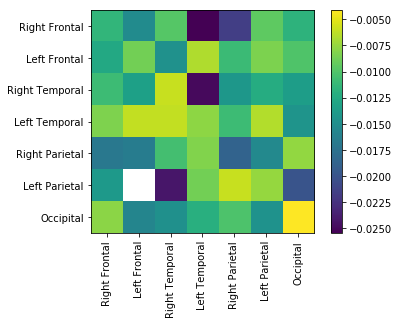

In [67]:
# shap_values_SVM = np.random.rand(5000)
curr_net_IDX = 2
pos_view = False
neg_view = True
chan_AB_mat = np.empty([len(chan_label_list),len(chan_label_list)])
chan_AB_mat[:] = np.nan
for i in range(len(chan_A_vect_IDX)):
    curr_A_IDX = int(chan_A_vect_IDX[i])
    curr_B_IDX = int(chan_B_vect_IDX[i])
    if pos_view:
        if shap_values_SVM[curr_net_IDX][0][i] > 0:
            chan_AB_mat[curr_A_IDX][curr_B_IDX] = np.nanmean([chan_AB_mat[curr_A_IDX][curr_B_IDX],shap_values_SVM[curr_net_IDX][0][i]])        
    elif neg_view:
        if shap_values_SVM[curr_net_IDX][0][i] < 0:
            chan_AB_mat[curr_A_IDX][curr_B_IDX] = np.nanmean([chan_AB_mat[curr_A_IDX][curr_B_IDX],shap_values_SVM[curr_net_IDX][0][i]])            
    else:
        chan_AB_mat[curr_A_IDX][curr_B_IDX] = np.nanmean([chan_AB_mat[curr_A_IDX][curr_B_IDX],shap_values_SVM[curr_net_IDX][0][i]])        

fig = plt.figure()
plt.matshow(chan_AB_mat, fignum=fig.number)
plt.xticks(range(len(chan_label_list)),chan_label_list_label,rotation=90)
plt.yticks(range(len(chan_label_list)),chan_label_list_label)
plt.gca().xaxis.tick_bottom()
plt.colorbar()
plt.show()

In [36]:
currFeatures_curated
Features_label = list({'CFC SI','PLI','PAC','COH','dPLI'})

In [113]:
XX_train = X[x_train_vect] 
XX_test = X[x_test_vect]

min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(np.concatenate((XX_train, XX_test)))

X_train_scale = min_max_scaler.transform(XX_train) 
X_test_scale = min_max_scaler.transform(XX_test)

[test_scores_SVM, training_scores_SVM, shap_explainer_SVM, shap_values_SVM, model_SVM] = classify_SVM(X_train_scale, X_test_scale,  Y[x_train_vect],  Y[x_test_vect], X_weights, kernel, shap_value_numPoints, compute_regression , compute_SHAP)


100%|██████████| 25/25 [2:07:01<00:00, 307.22s/it]  


In [114]:
import pickle

save_output = True
if save_output:
    # model_NN.save(curr_file_name + ".h5" )
    curr_file_name = "TB_1_SHAP"
    with open(curr_file_name + ".pickle", 'wb') as file_pi:
        pickle.dump([test_scores_SVM, training_scores_SVM, shap_values_SVM], file_pi)
shap_values_SVM

[array([[-0.02354864,  0.        ,  0.        , ...,  0.        ,
         -0.08081988,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.01130247,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.01516861,  0.00904093]]),
 array([[ 0.02530062,  0.        ,  0.        , ...,  0.        ,
          0.00586986,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.01356167,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.00643426, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         -0.01486276, -0.00783606]]),
 array([[-0.02101123,  0.        ,  0.        , ...,  0.        ,
         -0.01224492,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.01454537,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        , -0.00322365, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         -0.00369502,  0.        ]])]

In [4]:
import pickle

curr_file_name = "TB_1_SHAP.pickle"
[test_scores_SVM, training_scores_SVM, shap_values_SVM] = pickle.load(open(curr_file_name,'rb'))

In [9]:
import matplotlib.pyplot as plt
# import pandas as pd
from math import pi

def plot_radar_chart_group(df, group_var,plot_title,label_str,neg_vals):
 
    # ------- PART 1: Create background
     
    # number of variable
    categories=list(df)[1:]
    N = len(categories)
     
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
     
    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)
     
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
     
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories)
     
    # Get Ylims:
    steps = 3
    test = np.array(df.drop("Network",axis=1))
    Ymax = np.nanmax(test)
    Ymin = 0
    #Ymin = np.nanmin(test)
    # if neg_vals: # All negative values
    #    Ymax = np.nanmin(test)
    #    Ymin = 0
    # else: # All positive values
    #    Ymax = np.nanmax(test)
    #    Ymin = 0
        
    # step_size = (Ymax-Ymin)/steps
    #Yticks = np.array(range(Ymin,Ymax,step_size))
    [Yticks,Yticks_step] = np.linspace(Ymin,Ymax,steps,retstep=True)
    
    if neg_vals: # All negative values
        Yticks_label = [str(round(s,3)) for s in Yticks]
    else:
        Yticks_label = ["-" + str(round(s,3)) for s in Yticks]
    # np.append(Yticks,Yticks[-1] + Yticks_step)
    Ymax = Ymax + Yticks_step
    
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks(Yticks, Yticks_label, color="grey", size=7)
    plt.ylim(Ymin,Ymax)
     
     
    # ------- PART 2: Add plots
     
    # Plot each individual = each line of the data
    # I don't do a loop, because plotting more than 3 groups makes the chart unreadable
    
    color_vect = list()
    color_vect.append('b')
    color_vect.append('r')
    color_vect.append('y')
    color_vect.append('c')
    
    for i in df[group_var]:
        # Ind1
        values=df.loc[i].drop(group_var).values.flatten().tolist()
        values += values[:1]
        if not(np.isnan(values).any()):
            #ax.plot(angles, values, linewidth=1, linestyle='solid', label= group_var + " " + str(i))
            ax.plot(angles, values, linewidth=1, linestyle='solid', label= label_str)
            ax.fill(angles, values, color_vect[i], alpha=0.1)
        
    
    #    # Ind1
    #    values=df.loc[0].drop('group').values.flatten().tolist()
    #    values += values[:1]
    #    ax.plot(angles, values, linewidth=1, linestyle='solid', label="group A")
    #    ax.fill(angles, values, 'b', alpha=0.1)
    #     
    #    # Ind2
    #    values=df.loc[1].drop('group').values.flatten().tolist()
    #    values += values[:1]
    #    ax.plot(angles, values, linewidth=1, linestyle='solid', label="group B")
    #    ax.fill(angles, values, 'r', alpha=0.1)
     
    # Add legend
    # plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title(plot_title)


In [6]:
def plot_radar_chart_individual(df, group_var,plot_title,label_str,neg_vals=False):
    
    for i in range(len(df)):
        fig = plt.figure()
        curr_df = df.iloc[[i]]
        # plot_radar_chart_group(curr_df, group_var,group_var + " " + str(i))
        plot_radar_chart_group(curr_df, group_var,"",label_str[i],neg_vals)


C:\Users\Sanjay\Anaconda3\envs\Tensorflow\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
C:\Users\Sanjay\Anaconda3\envs\Tensorflow\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice


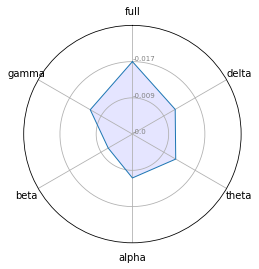

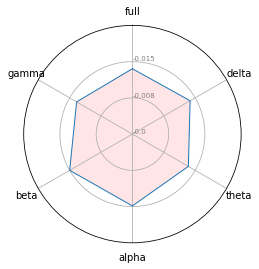

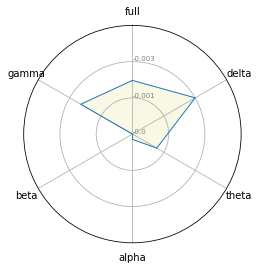

In [124]:
import matplotlib.pyplot as plt
import pandas as pd
# from plot_radar_chart_group import plot_radar_chart_group

pos_SHAP = True
neg_SHAP = False
SHAP_mask = np.append([],[nan_mat,np.ones(num_feats_per_type), nan_mat, np.ones(num_feats_per_type), np.ones(num_feats_per_type)])
#SHAP_mask = np.ones(num_feats_per_type*5)

window_SHAP = {"Network": [0, 1, 2]}
for i in range(len(window_label)):
    curr_select_IDX = window_vect_IDX == i
    window_SHAP[window_label[i]] = [np.nanmean(s[0][curr_select_IDX]) for s in shap_values_SVM]

#plot_radar_chart_individual(pd.DataFrame(window_SHAP),"Network","Window",network_label)

freq_SHAP = {"Network": [0, 1, 2]}
for i in range(len(freq_label)):
    curr_select_IDX = np.array(freqBand_A_vect) == i + 1
    #freq_SHAP[freq_label[i]] = [np.nanmean(s[0][curr_select_IDX]) for s in shap_values_SVM]
    temp_values = [s[0][curr_select_IDX]*SHAP_mask[curr_select_IDX] for s in shap_values_SVM]
    #temp_values = [s[SHAP_mask] for s in temp_values]
    if pos_SHAP:
        temp_values = [np.nanmean(s[s > 0]) for s in temp_values]
    elif neg_SHAP:
        temp_values = [abs(np.nanmean(s[s < 0])) for s in temp_values]
    # temp_values = [np.nanmean(s[s > 0]) for s in temp_values]
    # temp_values_nan = np.argwhere(np.isnan(temp_values))
    freq_SHAP[freq_label[i]] = np.nan_to_num(temp_values)

plot_radar_chart_individual(pd.DataFrame(freq_SHAP),"Network","Frequency",network_label,neg_SHAP)
# shap_values_SVM_nan = shap_values_SVM.copy()
#for i in range(len(shap_values_SVM_nan)):
#    #curr_vect = shap_values_SVM_nan[i][0] == 0
#    curr_vect = (shap_values_SVM_nan[i][0] < 0.0000001) & (shap_values_SVM_nan[i][0] > -0.0000001)
#    shap_values_SVM_nan[i][0][curr_vect] = np.nan


C:\Users\Sanjay\Anaconda3\envs\Tensorflow\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice


[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


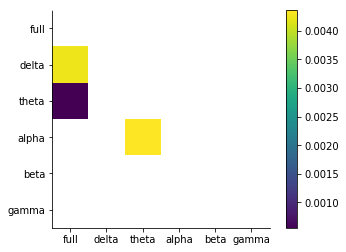

In [101]:
# shap_values_SVM = np.random.rand(5000)
curr_net_IDX = 2
pos_view = True
neg_view = False
nan_mat = np.empty(num_feats_per_type)
nan_mat[:] = np.nan
SHAP_mask = np.append([],[np.ones(num_feats_per_type), nan_mat, np.ones(num_feats_per_type), nan_mat , nan_mat])
# SHAP_mask = np.ones(num_feats_per_type*5)

freq_AB_mat = np.empty([len(freq_label),len(freq_label)])
freq_AB_mat[:] = np.nan
#masked_shap_values_SVM = shap_values_SVM[SHAP_mask].copy()
#masked_shap_values_SVM
for i in range(len(freqBand_A_vect)):
    curr_A_IDX = int(freqBand_A_vect[i]) - 1
    curr_B_IDX = int(freqBand_B_vect[i]) - 1
    if pos_view:
        if shap_values_SVM[curr_net_IDX][0][i] > 0:
            freq_AB_mat[curr_A_IDX][curr_B_IDX] = np.nanmean([freq_AB_mat[curr_A_IDX][curr_B_IDX],shap_values_SVM[curr_net_IDX][0][i]*SHAP_mask[i]])        
    elif neg_view:
        if shap_values_SVM[curr_net_IDX][0][i] < 0:
            freq_AB_mat[curr_A_IDX][curr_B_IDX] = np.nanmean([freq_AB_mat[curr_A_IDX][curr_B_IDX],shap_values_SVM[curr_net_IDX][0][i]*SHAP_mask[i]])            
    else:
        freq_AB_mat[curr_A_IDX][curr_B_IDX] = np.nanmean([freq_AB_mat[curr_A_IDX][curr_B_IDX],shap_values_SVM[curr_net_IDX][0][i]*SHAP_mask[i]])        

#fig = plt.figure()
fig, ax = plt.subplots()
#fig.matshow(np.transpose(freq_AB_mat), fignum=fig.number)
c = ax.matshow(np.transpose(freq_AB_mat))
#ax.axis("off")
ax.set_xticks(range(len(freq_label)))
ax.set_xticklabels(freq_label.copy())
ax.set_yticks(range(len(freq_label)))
ax.set_yticklabels(freq_label.copy())
ax.tick_params(axis="x",bottom=True, top=False, labelbottom=True, labeltop=False)
ax.spines["top"].set_color("white")
ax.spines["right"].set_color("white")
fig.colorbar(c);
##plt.xticks(range(len(freq_label)),freq_label,rotation=90)
##plt.yticks(range(len(freq_label)),freq_label)
##plt.gca().xaxis.tick_bottom()

[freqBand_A_vect[i] == freqBand_B_vect[i] for i in range(len(freqBand_A_vect))]

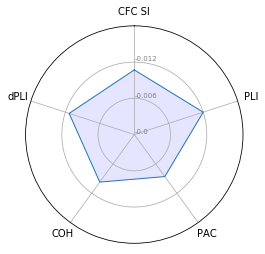

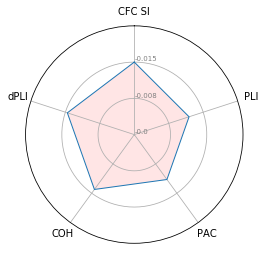

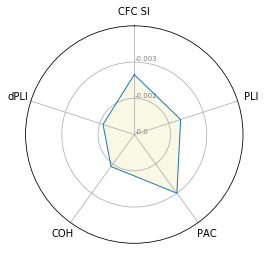

In [69]:
num_feats_per_type = 1000
pos_SHAP = True
neg_SHAP = False
feat_SHAP = {"Network": [0, 1, 2]}
for i in range(len(Features_label)):
    start_IDX_temp = i*num_feats_per_type + 1
    end_IDX_temp = start_IDX_temp + num_feats_per_type - 1
    curr_select_IDX = list(range(start_IDX_temp,end_IDX_temp))
    #freq_SHAP[freq_label[i]] = [np.nanmean(s[0][curr_select_IDX]) for s in shap_values_SVM]
    temp_values = [s[0][curr_select_IDX] for s in shap_values_SVM]
    if pos_SHAP:
        temp_values = [np.nanmean(s[s > 0]) for s in temp_values]
    elif neg_SHAP:
        temp_values = [abs(np.nanmean(s[s < 0])) for s in temp_values]
    # temp_values_nan = np.argwhere(np.isnan(temp_values))
    feat_SHAP[Features_label[i]] = np.nan_to_num(temp_values)

plot_radar_chart_individual(pd.DataFrame(feat_SHAP),"Network","Feature",network_label,neg_SHAP)


In [53]:
# Compute SHAP values for each output class:
shap_value_numPoints_perclass = 1
classes_to_fit = np.unique(Y)

shap_explainer = shap.KernelExplainer(curr_model_SVM.predict_proba, shap.kmeans(X_train_scale,10), link="logit")

curr_testIDX_list = list()
shap_values_list = list()
X_test_scale_shap_values_list = list()

for i in range(len(classes_to_fit)):
    curr_testIDX = Y[x_test_vect] == classes_to_fit[i]
    curr_X_test_scale = X_test_scale[curr_testIDX]
    X_test_scale_shap_values = np.random.choice(curr_X_test_scale.shape[0], shap_value_numPoints_perclass, replace=False)

    shap_values = shap_explainer.shap_values(curr_X_test_scale[X_test_scale_shap_values], nsamples="auto", l1_reg = "aic")
    
    curr_testIDX_list.append(curr_testIDX)
    shap_values_list.append(shap_values)
    X_test_scale_shap_values_list.append(X_test_scale_shap_values)

100%|██████████| 1/1 [05:38<00:00, 338.36s/it]


In [100]:
#shap_values_list_sorted = 
#for i in range(len(classes_to_fit)):
len(shap_values_list)
shap_values_SVM_temp = shap_values_list[0]
window_SHAP = [ for s in shap_values_SVM_temp]

In [65]:
# Plot the results:
import pandas as pd

# Convert to Pandas Dataframe with Variable Names:
X_train_scale_df = pd.DataFrame.from_dict({final_feature_labels_mRMR[n][0] : X_train_scale[:, n].flatten() for n in range(len(final_feature_labels_mRMR))})
X_test_scale_df = pd.DataFrame.from_dict({final_feature_labels_mRMR[n][0] : X_test_scale[:, n].flatten() for n in range(len(final_feature_labels_mRMR))})

for i in range(len(classes_to_fit)):
    shap.summary_plot(shap_values_list[i], X_test_scale_df.iloc[X_test_scale_shap_values_list[i]],plot_type = "violin") # replace with X_test_scale_shap_values_NN
    #shap.summary_plot(curr_shap_values_NN, X_test_scale_df.iloc[X_test_scale_shap_values_NN],plot_type = "bar")